# Uga Dooga. Тестовое задание

Выполнил: Самаркин Виталий - Data Analyst

**Описание**

Мобильная игра зарабатывает на показе рекламы. Есть несколько форматов:
- int – полноэкранная реклама; 
- banner – горизонтальный баннер, висит внизу экрана пока юзер играет; 
- rv – видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы. 

Информация о каждом показе отправляется в аналитику. В нашем распоряжении таблица данных о показах рекламы. 

**Таблица**

- profile_id – id юзера
- os_version - версия ос
- device_manufacturer - производитель устройства
- device_model - модель устройства
- device_type - тип устройства (смартфон, планшет и т.п)
- device_locale - локация (???)
- event_name - название события
- event_json - содержит json структуру, в которой:
    - ad_type – формат рекламы (int, banner или rv)
    - placement – когда/где был показ рекламы в игре
    - view_index – номер показа конкретного формата рекламы для юзера (не поддерживается для баннеров)
    - revenue – доход от конкретного показа рекламы (eCPM = revenue * 1000)
    - ads_ltv – накапливающийся доход от рекламы, равен сумме всех revenue юзера
    - network_name – рекламная сеть, от которой был показ
    - и др.
- event_datetime и event_timestamp - дата и время ивента
- event_receive_datetime и event_receive_timestamp - (???)
- connection_type - тип соединения
- operator_name - название мобильного оператора
- country_iso_code - код страны
- city - город

**Задачи**

Выяснить насколько отличается метрика eCPM в зависимости от географии (города) юзера, версии ОС и других параметров. Интересны любые инсайты и находки по eCPM-ам.

1. Для каждого формата рекламы:
    - построить распределение средних eCPM-ов юзеров
    - построить распределение eCPM-ов по городам, версиям ОС
    - построить распределение доходов по городам, версиям ОС
2. Учесть статистическую значимость (отобразить, отфильтровать незначимое или хотя бы прокомментировать). Объяснить решение.
3. Описать наблюдения и вывод по исследованию.
4. Исследовать:
    - Какой процент доходов содержит информацию о городе юзера
    - Зависит ли eCPM от времени дня

## Обзор данных

**Импорты**

In [1]:
import pandas as pd
import numpy as np

import json 

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st

**Таблица**

In [2]:
df = pd.read_csv('ad_revenue_events.csv')

**Обзор**

In [3]:
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


Чтобы сделать первые выводы по таблице для предобработки нужно для начала вытащить необходимые значения из столбца event_json в отдельные столбцы.

### JSON-значения

Для удобства работы достанем необходимые значения из столбца event_json в отдельные столбцы. Посмотрим для начала - что именно там содержится. 

In [4]:
json.loads(df.loc[0,'event_json'])

{'ad_type': 'banner',
 'placement': '',
 'view_index': 1,
 'session_view_index': 0,
 'cur_ticks': 637795729492245130,
 'session_length': 705.8807,
 'revenue': 0.000510313,
 'ads_ltv': 0.487876676518837,
 'ecpm_sma': 0.511508107185364,
 'normalized_ecpm_sma': 0.511508107185364,
 'value': 0.000510313,
 'currency': 'USD',
 'ad_country_code': 'US',
 'network_name': 'Google AdMob',
 'ad_unit_id': '64c6b1114ea8c1cc',
 'ad_network_placement': 'ca-app-pub-7511632782617496/8825263691',
 'creativeId': 'CJ3XirfD5vUCFYPnKAUdG3MOYQ'}

Ключей-значений очень много. В условиях работы стоило бы обратиться к коллегам и уточнить смысл тех, что интуитивно не понятны. Сейчас же я возьму только те, что сходу понятны и могут быть полезны для исследования. Поскольку наша задача изучить как влияют на eCPM различные параметры, то мне пригодятся данные для расчета eCPM (то есть - revenue) и все, что похоже на параметры. В таком случае я возьму:

- ad_type – формат рекламы
- placement - когда/где был показ рекламы в игре
- view_index - номер показа конкретного формата рекламы для юзера (не поддерживается для баннеров)
- revenue – доход от конкретного показа рекламы
- currency - вдруг у кого-то это не USD и нужно будет конвертировать валюту для сравнения
- network_name - рекламная сеть

Вытащим нужные нам ключи, пройдемся по каждому из них и выгрузим значения во отдельные столбцы. 

In [5]:
keys = ['ad_type', 'placement', 'view_index', 'revenue', 'currency', 'network_name']

In [6]:
for key in keys:
    df[key] = df['event_json'].apply(lambda x: json.loads(x).get(key))

In [7]:
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,...,connection_type,operator_name,country_iso_code,city,ad_type,placement,view_index,revenue,currency,network_name
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,...,wifi,NaN,US,Norwalk,banner,,1,0.000510,USD,Google AdMob
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,...,wifi,NaN,US,Norwalk,banner,,1,0.000510,USD,Google AdMob
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,...,wifi,Verizon,US,Charlotte,banner,,1,0.002386,USD,APPLOVIN_EXCHANGE
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,...,wifi,T-Mobile,US,Cocoa,int,next_level,1,0.013894,USD,AppLovin
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,...,cell,Verizon,US,NaN,banner,,1,0.006828,USD,Google AdMob


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   profile_id               860065 non-null  object 
 1   os_version               860079 non-null  object 
 2   device_manufacturer      860079 non-null  object 
 3   device_model             860079 non-null  object 
 4   device_type              860079 non-null  object 
 5   device_locale            860079 non-null  object 
 6   event_name               860079 non-null  object 
 7   event_json               860079 non-null  object 
 8   event_datetime           860079 non-null  object 
 9   event_timestamp          860079 non-null  int64  
 10  event_receive_datetime   860079 non-null  object 
 11  event_receive_timestamp  860079 non-null  int64  
 12  connection_type          860079 non-null  object 
 13  operator_name            841200 non-null  object 
 14  coun

**Выводы по таблице**

- 22 столбца и 860 тысяч строк
- Пропуски в столбцах: profile_id, operator_name, и city
- Изменить тип данных в датах
- Убрать лишнюю информацию о датах
- Проверить категориальные столбцы на дубликаты и корректные написания
- Убрать столбцы с единственным значением
- Убрать неинформативные столбцы
- Сразу рассчитать в таблицу eCPM
- Проверить на дубликаты

## Предобработка

### Пропуски

**Столбец profile_id**

In [9]:
df[df['profile_id'].isna() == True].shape[0]

14

Пропусков в этом столбце очень мало. Можем просто удалить эти строчки из таблицы.

In [10]:
df = df[df['profile_id'].isna() == False]

**Столбцы operator_name и city**

In [11]:
df[df['operator_name'].isna() == True].shape[0]

18879

In [12]:
df[df['city'].isna() == True].shape[0]

323694

В столбце с оператором 18879 пропусков, а в столбце с городом аж 323694. Это достаточно много. Есть идея попробовать восстановить их. 

Что если заполнить их по profile_id? Найти город и оператора для каждого пользователя (насколько это возможно) и заполнить все NaN-значения в других строчках этого пользователя. 

Чтобы проверить, сработает ли это решение, нужно изучить характер значений. Я удалил весь код этого этапа и сразу опишу выводы. 

- Действительно встречаются ситуации, когда город и оператор не указан лишь в некоторой части всех строчек. 
- Но, есть проблемка. У пользователя может быть больше один оператор и один город. Я встретил максимум 6 разных городов и 6 разных операторов у одного пользователя. 
- Выходит, что корректно восстановить значения не получится. Если у пользователя несколько разных городов, то каким из них заполнять пропуски? А даже если у одного пользователя только 1 оператор и 1 город, может оказаться так, что в NaN-значения как раз был другой город и другой мобильный оператор. 

Итого: оставим эти пропуски как есть. 

### Даты

Есть подозрение, что столбцы event_timestamp и event_datetime - это одно и то же и один из них можно удалить. Проверим. 

In [13]:
df['event_datetime']

0         2022-02-04 20:02:28
1         2022-02-04 20:02:45
2         2022-02-05 17:53:05
3         2022-02-06 17:09:01
4         2022-02-06 17:15:38
                 ...         
860074    2022-02-03 08:29:27
860075    2022-02-03 02:12:51
860076    2022-02-03 02:13:06
860077    2022-02-03 02:13:17
860078    2022-02-03 03:11:44
Name: event_datetime, Length: 860065, dtype: object

In [14]:
pd.to_datetime(df['event_timestamp'], unit='s')

0        2022-02-04 17:02:28
1        2022-02-04 17:02:45
2        2022-02-05 14:53:05
3        2022-02-06 14:09:01
4        2022-02-06 14:15:38
                 ...        
860074   2022-02-03 05:29:27
860075   2022-02-02 23:12:51
860076   2022-02-02 23:13:06
860077   2022-02-02 23:13:17
860078   2022-02-03 00:11:44
Name: event_timestamp, Length: 860065, dtype: datetime64[ns]

В целом - так и есть, но между этими столбцами разница ровно в 3 часа. Проверим так же столбцы event_receive_datetime и event_receive_timestamp.

In [15]:
df['event_receive_datetime']

0         2022-02-06 17:58:19
1         2022-02-06 17:58:19
2         2022-02-06 16:59:29
3         2022-02-06 17:09:24
4         2022-02-06 17:16:16
                 ...         
860074    2022-02-03 08:29:37
860075    2022-02-03 02:14:48
860076    2022-02-03 02:14:48
860077    2022-02-03 02:14:48
860078    2022-02-03 21:12:34
Name: event_receive_datetime, Length: 860065, dtype: object

In [16]:
pd.to_datetime(df['event_receive_timestamp'], unit='s')

0        2022-02-06 14:58:19
1        2022-02-06 14:58:19
2        2022-02-06 13:59:29
3        2022-02-06 14:09:24
4        2022-02-06 14:16:16
                 ...        
860074   2022-02-03 05:29:37
860075   2022-02-02 23:14:48
860076   2022-02-02 23:14:48
860077   2022-02-02 23:14:48
860078   2022-02-03 18:12:34
Name: event_receive_timestamp, Length: 860065, dtype: datetime64[ns]

Cитуация аналогичная. Почему так происходит и какая из этих дат корректная - не понятно. Стоит пообщаться с коллегами на тему того как сохраняются эти значения и почему между ними такая разница. Для нашей задачи оставим лишь значения из столбцов datetime и переведем их в нужный тип данных. 

In [17]:
df['event_datetime'] = pd.to_datetime(df['event_datetime'], format='%Y-%m-%d %H:%M:%S')

In [18]:
df['event_receive_datetime'] = pd.to_datetime(df['event_receive_datetime'], format='%Y-%m-%d %H:%M:%S')

In [19]:
df.drop(['event_receive_timestamp', 'event_timestamp'], axis=1, inplace=True)

### Категориальные столбцы

Посмотрим какие значения находятся в таких столбцах и нет ли в них некорректных написаний одного и того же значения. 

In [20]:
df['ad_type'].unique()

array(['banner', 'int', 'rv'], dtype=object)

In [21]:
df['network_name'].unique()

array(['Google AdMob', 'APPLOVIN_EXCHANGE', 'AppLovin', 'Facebook'],
      dtype=object)

In [22]:
df['os_version'].unique()

array(['11', '10', '12', '9', '8.0.0', '6.0.1', '8.1.0', '7.0', '7.1.2',
       '7.1.1', '5.0.2'], dtype=object)

In [23]:
df['device_manufacturer'].unique()

array(['Samsung', 'Google', 'TCL', 'LG', 'OnePlus', 'Motorola',
       'Teracube', 'Lenovo', 'T-Mobile', 'Verizon Wireless', 'Xiaomi',
       'Alcatel', 'Cricket', 'Blu', 'Kyocera', 'Maxwest', 'Nokia', 'FIH',
       'Dish', 'Schok', 'deejoy', 'AT&T', 'Zte', 'Redmi', 'Yulong',
       'Wiko', 'Huawei', 'Onn (Walmart)', 'AEEZO', 'Asus', 'JOYAR',
       'POCO', 'Ulefone', 'Razer'], dtype=object)

In [24]:
df['device_type'].unique()

array(['tablet', 'phone'], dtype=object)

In [25]:
df['device_locale'].unique()

array(['en_US', 'en_GB', 'en_NL', 'ko_KR', 'en_CA', 'fr_FR', 'en_IN',
       'en_AU', 'zh-Hant_TW'], dtype=object)

In [26]:
df['connection_type'].unique()

array(['wifi', 'cell', 'unknown'], dtype=object)

В этих столбцах все ок. 

In [27]:
df['placement'].unique()

array(['', 'next_level', 'replay', 'lose_offer_attempt',
       'game_repeating_reward', 'double_coins',
       'game_repeating_reward_int', 'lose_offer_attempt_int',
       'double_coins_int'], dtype=object)

В этом столбце есть пустое значние, которое стоить заменить на nan. 

In [28]:
df['placement'].replace([' ', ''], np.NaN, inplace=True)

In [29]:
df['event_name'].unique()

array(['c_ad_revenue'], dtype=object)

In [30]:
df['country_iso_code'].unique()

array(['US'], dtype=object)

In [31]:
df['currency'].unique()

array(['USD'], dtype=object)

В этих столбцах содержатся единственные значения, а значит они не информативны. Можем избавиться от них.

In [32]:
df.drop(['event_name', 'country_iso_code', 'currency'], axis=1, inplace=True)

Остались три столбца с большим количеством разных значений. 

In [33]:
df['operator_name'].nunique()

92

In [34]:
df['operator_name'].unique()

array([nan, 'Verizon', 'T-Mobile', 'Verizon ', 'AT&T', 'U.S. Cellular',
       'Republic', 'Spectrum', 'giffgaff', '\xa0', 'Metro by T-Mobile',
       'Home', 'cricket', 'T-Mobile - US', 'HOME', 'Verizon Wireless',
       ' ', 'Visible', 'CC Network', 'Sprint', 'AT&T Wireless Inc.',
       'Sprint Spectrum', 'Extended Network', 'Searching for Service',
       'Boost Mobile', 'Google Fi', 'Mint', 'Cellcom', 'AT&T MicroCell',
       'T-Mobile ', 'Xfinity Mobile', 'MetroPCS', 'Ting',
       'Roaming Indicator On', 'Optimum', 'Tracfone', 'Liberty',
       'Family Mobile', 'H2O', 'Extended', 'Xfinity Mobile Wi-Fi Calling',
       'Roam', 'Assurance Wireless', 'FirstNet',
       'North Carolina RSA 3 Cellular Tel. Co.', 'TracFone', 'Pure Talk',
       'EE', 'iD', 'USCellular', 'Red Pocket', 'Preferred System',
       'Freedom', 'Orange EG', 'VIRGIN', 'GCI Communication Corp.',
       'SKTelecom', 'Tsel-PakaiMasker', 'C Spire',
       'T-Mobile | International', 'Union Wireless', 'TELUS',
   

Здесь сразу видны некоторые ошибки:
- Пробел или символ '\r' в конце названий
- Просто значение ' ' (пробел)

In [35]:
df['device_model'].nunique()

284

In [36]:
df['device_model'].unique()

array(['Galaxy Tab S6', 'Pixel 2', 'Galaxy S9', 'Galaxy A51 5G',
       'TCL 10L', 'Galaxy S21 Ultra 5G', 'Galaxy S10',
       'Galaxy S20 Ultra 5G', 'Galaxy S9+', 'K71', 'Pixel 4 XL',
       'Galaxy A21', 'VELVET', 'Galaxy Note20 Ultra 5G',
       'OnePlus 9 Pro 5G', 'Galaxy J5', 'SM-G996U', 'moto g(7) power',
       'Galaxy S21 5G', 'Galaxy A32 5G', 'Galaxy A20', 'Galaxy Note10+',
       'Pixel 6 Pro', 'Galaxy S10+', 'SM-G991U', 'OnePlus Nord N100',
       'Galaxy Note9', 'Galaxy S10e', 'Galaxy S20+ 5G', 'moto g pure',
       'LG V60 ThinQ', 'Galaxy Note10+ 5G', 'Galaxy Note20 5G',
       'Galaxy Tab S6 Lite', 'moto g stylus', 'Galaxy S20 5G',
       'LG G8 ThinQ™', 'Pixel 4a', 'LG G7 ThinQ', 'Galaxy S8',
       'OnePlus 9 5G', 'Pixel 3', 'Teracube_One', 'Galaxy Z Flip3 5G',
       'moto g fast', 'Galaxy A11', 'Lenovo Smart Tab M8',
       'Galaxy S20 FE 5G', 'Galaxy Note8', 'Galaxy A51', 'Pixel 6',
       'Galaxy S7', 'Galaxy A71 5G', 'Galaxy S8+', 'LG V35 ThinQ',
       'moto z4', 

Чисто визуально таких ошибок в названиях моделей не наблюдается.

In [37]:
df['city'].nunique()

920

In [38]:
df['city'].unique()

array(['Norwalk', 'Charlotte', 'Cocoa', nan, 'Columbus', 'Jamestown',
       'Austin', 'Minot', 'Milwaukee', 'McKeesport', 'New Albany',
       'Kansas City', 'Ypsilanti', 'Indianapolis', 'Geneva', 'Tampa',
       'Saint Paul', 'Trenton', 'Cherry Hill', 'Lafayette', 'New York',
       'Dayton', 'Alexandria', 'Hayward', 'San Francisco', 'Decatur',
       'Birmingham', 'Madison', 'Sioux Falls', 'Roosevelt',
       'Grand Rapids', 'Wichita', 'Louisville', 'Overland Park',
       'Gainesville', 'Grants Pass', 'Council Bluffs', 'Shreveport',
       'Springfield', 'DeKalb', 'West Jordan', 'Kalispell', 'Portland',
       'Farmingville', 'Schenectady', 'Oklahoma City', 'Jacksonville',
       'Dallas', 'Santa Maria', 'Madison Heights', 'Minneapolis',
       'Nashville', 'Houston', 'Cape Coral', 'Atlanta', 'Sacramento',
       'Denham Springs', 'Pittsburgh', 'Lenoir City', 'Phoenix',
       'Greenville', 'Augusta', 'Philadelphia', 'Detroit', 'Shelbyville',
       'Fishers', 'Claremore', 'Wasilla

Оценить все написания городов уже сложнее, но чисто визуально в них тоже все в порядке. 

Тем не менее, на всякий случай ДЛЯ ВСЕХ столбцов проделаем следующее:
- Сменим регистр
- Уберем пробел в начале или в конце строки
- Уберем символ '\r' в конце строки
- Переведем значение ' ' в NaN

In [39]:
df['device_model'] = df['device_model'].str.lower()
df['operator_name'] = df['operator_name'].str.lower()
df['city'] = df['city'].str.lower()

In [40]:
df['operator_name'] = df['operator_name'].str.strip(' \r')
df['device_model'] = df['device_model'].str.strip(' \r')
df['city'] = df['city'].str.strip(' \r')

In [41]:
df['device_model'].replace([' ', '', 'nan'], np.NaN, inplace=True)
df['operator_name'].replace([' ', '', 'nan'], np.NaN, inplace=True)
df['city'].replace([' ', '', 'nan'], np.NaN, inplace=True)

Посмотрим изменилось ли количество значений.
Было:
- device_model - 284
- operator_name - 92
- city - 920

Стало:

In [42]:
df['device_model'].nunique()

284

In [43]:
df['operator_name'].nunique()

84

In [44]:
df['city'].nunique()

920

Судя по всему проблемы были только в столбце с операторами. 

### Рассчет eCPM

Сразу добавим в таблицу eCPM для каждого показа. 

In [45]:
df['ecpm'] = df['revenue'] * 1000

### Дубликаты

In [46]:
df.duplicated().sum()

0

Полных дубликатов нет. Предобработка завершена. Можем приступить к следующему этапу. 

## EDA: Исследовательский анализ данных

In [47]:
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_json,event_datetime,event_receive_datetime,connection_type,operator_name,city,ad_type,placement,view_index,revenue,network_name,ecpm
0,JLjpGzDHBQm,11,Samsung,galaxy tab s6,tablet,en_US,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,2022-02-06 17:58:19,wifi,NaN,norwalk,banner,NaN,1,0.000510,Google AdMob,0.510313
1,JLjpGzDHBQm,11,Samsung,galaxy tab s6,tablet,en_US,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,2022-02-06 17:58:19,wifi,NaN,norwalk,banner,NaN,1,0.000510,Google AdMob,0.510313
2,JLkVacrzHY6,11,Google,pixel 2,phone,en_US,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,2022-02-06 16:59:29,wifi,verizon,charlotte,banner,NaN,1,0.002386,APPLOVIN_EXCHANGE,2.386163
3,JMC6wG3cX0f,10,Samsung,galaxy s9,phone,en_US,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,2022-02-06 17:09:24,wifi,t-mobile,cocoa,int,next_level,1,0.013894,AppLovin,13.893784
4,JLzWWTJfi1b,10,Samsung,galaxy s9,phone,en_US,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,2022-02-06 17:16:16,cell,verizon,NaN,banner,NaN,1,0.006828,Google AdMob,6.827570


### Диапозон данных

In [48]:
df['event_datetime'].describe()

C:\Users\V2BE2~1.SAM\AppData\Local\Temp/ipykernel_11188/119273906.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['event_datetime'].describe()


count                  860065
unique                 322811
top       2022-02-06 19:00:31
freq                      555
first     2022-01-29 17:42:32
last      2022-02-07 23:59:59
Name: event_datetime, dtype: object

In [49]:
df['event_datetime'].max() - df['event_datetime'].min()

Timedelta('9 days 06:17:27')

**Вывод:** в нашем распоряжении данных за 9 дней: с 29 января по 7 февраля. 

### Распределение событий по дням

In [50]:
df['event_date'] = df['event_datetime'].dt.date

In [51]:
events_per_date = df.groupby('event_date', as_index=False) \
    .agg({'profile_id':'count'}) \
    .rename(columns={'profile_id':'events_count'})

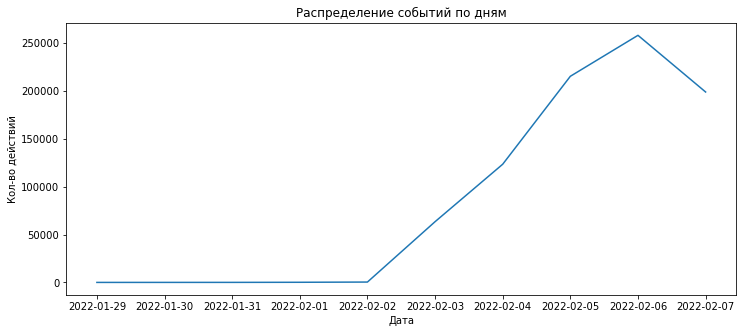

In [52]:
plt.figure(figsize=(12,5))
sns.lineplot(data=events_per_date, x='event_date', y='events_count')
plt.title('Распределение событий по дням')
plt.xlabel('Дата')
plt.ylabel('Кол-во действий');

**Вывод:** Имеем либо неполные данные, либо очень низкую активность до 3 февраля. 

### Распределение значений выручки с одного показа

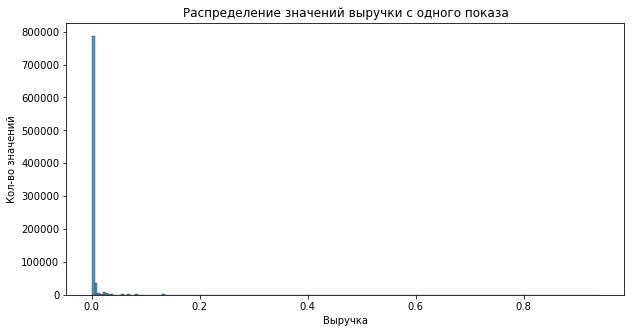

In [53]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='revenue', binwidth=0.005)
plt.title('Распределение значений выручки с одного показа')
plt.xlabel('Выручка')
plt.ylabel('Кол-во значений');

Видим огромный пик около нуля (вдруг у нас в таблице есть нулевые значения дохода?) и длинный хвост. Такой график не информативен. Может показаться, что есть выбросы, от которых стоит избавиться, но дело кажется в том, что разная по формату реклама лежит в разных ценовых диапозонах. Баннеры - дешевые, а ревордэд видео - дорогое. Проверим это. 

In [54]:
df.query('revenue == 0')

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_json,event_datetime,event_receive_datetime,connection_type,operator_name,city,ad_type,placement,view_index,revenue,network_name,ecpm,event_date
670440,JL7PaV98HXg,9,Samsung,galaxy s8,phone,en_US,"{""ad_type"":""int"",""placement"":""replay"",""view_in...",2022-02-02 07:25:22,2022-02-06 22:10:25,wifi,cc network,glastonbury,int,replay,4,0.0,Facebook,0.0,2022-02-02


Нулевое значение только одно. От него сразу можно избавиться - это скорее всего какой-то баг. 

In [55]:
df = df.query('revenue != 0')

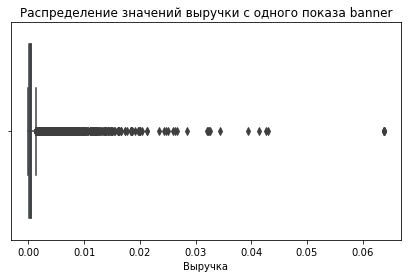

In [56]:
plt.figure(figsize=(7,4))
sns.boxplot(data=df.query('ad_type == "banner"'), x='revenue')
plt.title('Распределение значений выручки с одного показа banner')
plt.xlabel('Выручка');

Видим, что все значения выручки лежат в диапозоне от 0 до 0.06. Нет критичных выбросов, но крайние значения хвоста могут немного искажать среднее. 

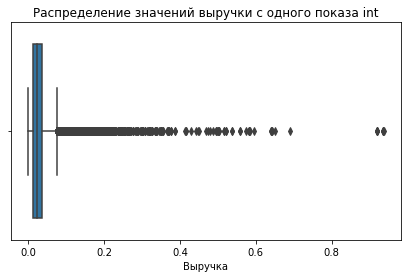

In [57]:
plt.figure(figsize=(7,4))
sns.boxplot(data=df.query('ad_type == "int"'), x='revenue')
plt.title('Распределение значений выручки с одного показа int')
plt.xlabel('Выручка');

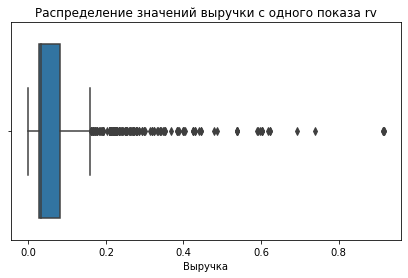

In [58]:
plt.figure(figsize=(7,4))
sns.boxplot(data=df.query('ad_type == "rv"'), x='revenue')
plt.title('Распределение значений выручки с одного показа rv')
plt.xlabel('Выручка');

Форматы int и rv куда более похожи. Основная масса значений у них в пределах 0 - 0.2. Это больше чем, у баннеров, а хвост распределения уходит до 0.8. Опять же - критичных выбросов нет, но крайние значения хвоста могут искажать среднее.

Я не хочу удалять значения, потому что мы можем лишиться информации: вдруг высокие суммы вырчуки по показу (от 0.4 до 0.8) связаны с определенными факторами, а мы их удалим. А для оценки среднего значения будем использовать медиану.

In [59]:
print('Медианные значения выручки с одного показа')
print('banner: {:.5f} USD'.format(df.query('ad_type == "banner"')['revenue'].median()))
print('int: {:.5f} USD'.format(df.query('ad_type == "int"')['revenue'].median()))
print('rv: {:.5f} USD'.format(df.query('ad_type == "rv"')['revenue'].median()))

Медианные значения выручки с одного показа
banner: 0.00049 USD
int: 0.02140 USD
rv: 0.03147 USD


### Распределение количества показов на юзера

In [60]:
events_per_user = df.groupby('profile_id', as_index=False) \
    .agg({'event_datetime':'count'}) \
    .rename(columns={'event_datetime':'events_count'})

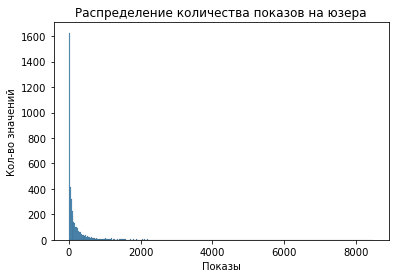

In [61]:
sns.histplot(data=events_per_user, x='events_count')
plt.title('Распределение количества показов на юзера')
plt.xlabel('Показы')
plt.ylabel('Кол-во значений');

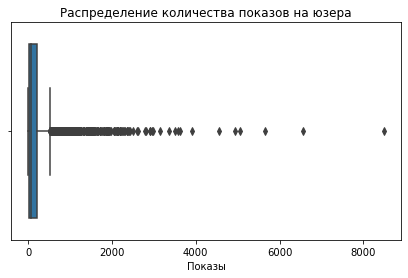

In [62]:
plt.figure(figsize=(7,4))
sns.boxplot(data=events_per_user, x='events_count')
plt.title('Распределение количества показов на юзера')
plt.xlabel('Показы');

Основная масса значений лежит в пределах 0 - 750 показов, но есть пользователи, которые видят рекламу гораздо чаще. Хвост распределения уходит аж до 8000 тысяч. 

In [63]:
events_per_user['events_count'].median()

57.0

### Доля каждого формата рекламы

In [64]:
event_per_ad_type = df.groupby('ad_type', as_index=False) \
    .agg({'profile_id':'count'}) \
    .rename(columns={'profile_id':'events_count'})

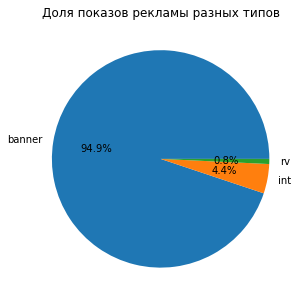

In [65]:
plt.figure(figsize=(5,5))
plt.pie(data=event_per_ad_type, 
        x='events_count', 
        labels='ad_type',
        autopct='%1.1f%%')
plt.title('Доля показов рекламы разных типов')
plt.show()

Основная масса всех показов приходится на баннеры: почти 95%. А теперь посмотрим на доли по выручке. 

In [66]:
revenue_per_ad_type = df.groupby('ad_type', as_index=False) \
    .agg({'revenue':'sum'}) \
    .rename(columns={'revenue':'sum_revenue'})

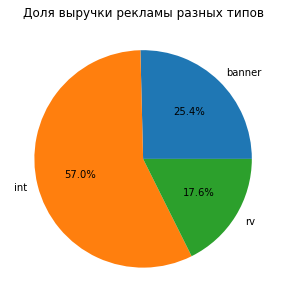

In [67]:
plt.figure(figsize=(5,5))
plt.pie(data=revenue_per_ad_type, 
        x='sum_revenue', 
        labels='ad_type',
        autopct='%1.1f%%')
plt.title('Доля выручки рекламы разных типов')
plt.show()

95% показов баннеров делают всего лишь 25% выручки. В том время как 0.4% показа rv приносят почти 18% выручки. 

### Доля доходов с информацией о городе юзера

In [68]:
df[df['city'].isna() == False]['revenue'].sum() / df['revenue'].sum()

0.6357694408285329

64% процента доходов содержат информацию о городе юзера. А какое количество показов содержит город юзера?

In [69]:
df[df['city'].isna() == False].shape[0] / df.shape[0]

0.6236396361201026

Практически то же самое - 62%. Смещения нет. Это скорее всего значит, что показы всех форматов рекламы пропорционально не имеют информацию о городе. 

## Исследование

### Формат banner

**Распределение средних eCPM-ов юзеров**

Поскольку мы помним большой хвост у распределений, то по каждому юзеру будем смотреть медиану. 

In [70]:
BANNER_ecmp_per_user = df.query('ad_type == "banner"') \
    .groupby('profile_id', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'})

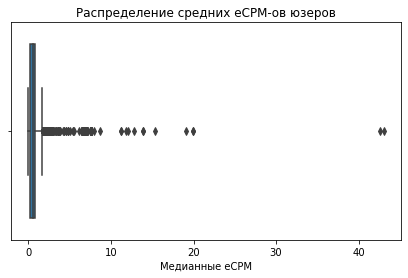

In [71]:
plt.figure(figsize=(7,4))
sns.boxplot(data=BANNER_ecmp_per_user, x='median_ecpm')
plt.title('Распределение средних eCPM-ов юзеров')
plt.xlabel('Медианные eCPM');

Посмотрим на распределение без хвоста. 

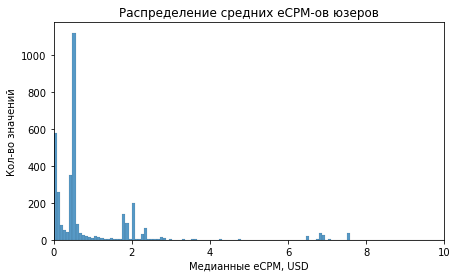

In [72]:
plt.figure(figsize=(7,4))
sns.histplot(data=BANNER_ecmp_per_user, x='median_ecpm')
plt.xlim(0,10)
plt.title('Распределение средних eCPM-ов юзеров')
plt.xlabel('Медианные eCPM, USD')
plt.ylabel('Кол-во значений');

Основная масса значений лежит от 0 до 2 USD, а еще - встречается какое-то количество значений от 6 до 8 USD.

**Распределение eCPM-ов по городам**

Городов достаточно много, поэтому посмотрим топ-20.

In [73]:
BANNER_ecmp_per_city = df.query('ad_type == "banner"') \
    .groupby('city', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

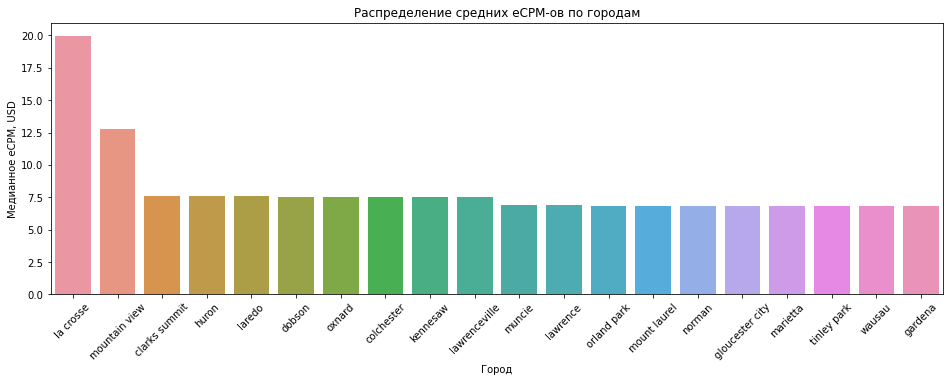

In [74]:
plt.figure(figsize=(16,5))
sns.barplot(data=BANNER_ecmp_per_city.head(20), y='median_ecpm', x='city')
plt.title('Распределение средних eCPM-ов по городам')
plt.xlabel('Город')
plt.ylabel('Медианное eCPM, USD')
plt.xticks(rotation=45);

Видим ТОП-2 города, значения которых явно отличаются от основной массы: la crosse и mountain view, но у того и другого города очень мало показов, чтобы сделать какой-то вывод, 

**Вывод**

По такому количеству наблюдений сложно сделать корректный вывод о том, что mountain view и la crosse действительно значимо отличаются по метрике eCPM. Единственное, что мы видим - самые большие значения находятся около 7 - 7.5 USD при медианном значении в 4.9 USD.

**Распределение eCPM-ов по версиям ОС**

In [75]:
BANNER_ecmp_per_os = df.query('ad_type == "banner"') \
    .groupby('os_version', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

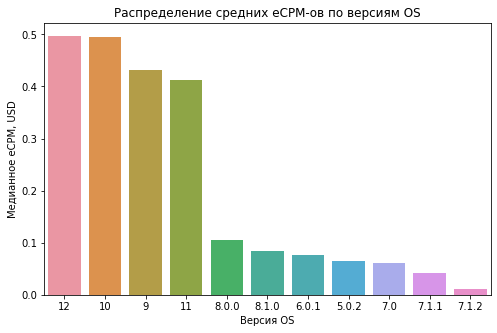

In [76]:
plt.figure(figsize=(8,5))
sns.barplot(data=BANNER_ecmp_per_os, y='median_ecpm', x='os_version')
plt.title('Распределение средних eCPM-ов по версиям OS')
plt.xlabel('Версия OS')
plt.ylabel('Медианное eCPM, USD');

Куда более наглядная картина. **Более новые версии OS (12, 10, 9, 11) показывают минимум в 4 раза больший eCPM в сравнении со старыми** Проверим - достаточно ли у нас наблюдений для такого вывода. 

In [77]:
BANNER_events_per_os_version = df.query('ad_type == "banner"') \
    .groupby('os_version', as_index=False) \
    .agg({'profile_id':'count'}) \
    .rename(columns={'profile_id':'events_count'}) \
    .sort_values(by='events_count', ascending=False)

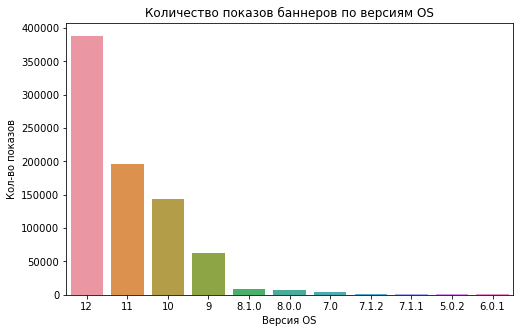

In [78]:
plt.figure(figsize=(8,5))
sns.barplot(data=BANNER_events_per_os_version, y='events_count', x='os_version')
plt.title('Количество показов баннеров по версиям OS')
plt.xlabel('Версия OS')
plt.ylabel('Кол-во показов');

Ровно та же картина и по количеству показов.

**Вывод**

Чем новее версия OS, тем больший eCPM она демонстрирует и тем больше показов она привлекает. 

**Распределение доходов по городам**

In [79]:
BANNER_total_revenue_per_city = df.query('ad_type == "banner"') \
    .groupby('city', as_index=False) \
    .agg({'revenue':'sum'}) \
    .rename(columns={'revenue':'revenue_sum'}) \
    .sort_values(by='revenue_sum', ascending=False)

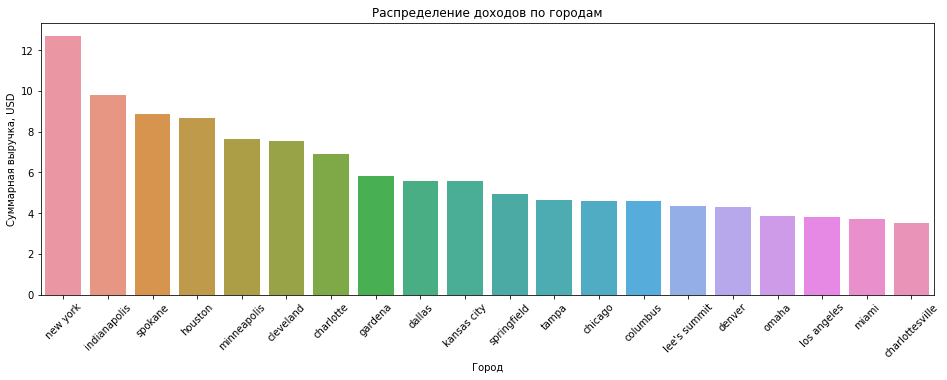

In [80]:
plt.figure(figsize=(16,5))
sns.barplot(data=BANNER_total_revenue_per_city.head(20), y='revenue_sum', x='city')
plt.title('Распределение доходов по городам')
plt.xlabel('Город')
plt.ylabel('Суммарная выручка, USD')
plt.xticks(rotation=45);

Видим, что как минимум первая пятерка городов по доходов не попала даже в топ-20 по eCPM. Вывод: у нас есть более дорогие баннеры, но без достаточного количества показов они не генерируют много выручки. 

**Распределение доходов по версиям OS**

In [81]:
BANNER_total_revenue_per_os = df.query('ad_type == "banner"') \
    .groupby('os_version', as_index=False) \
    .agg({'revenue':'sum'}) \
    .rename(columns={'revenue':'revenue_sum'}) \
    .sort_values(by='revenue_sum', ascending=False)

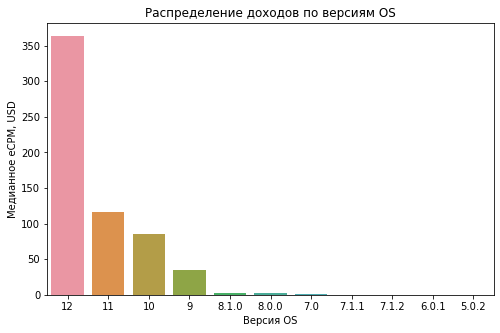

In [82]:
plt.figure(figsize=(8,5))
sns.barplot(data=BANNER_total_revenue_per_os, y='revenue_sum', x='os_version')
plt.title('Распределение доходов по версиям OS')
plt.xlabel('Версия OS')
plt.ylabel('Медианное eCPM, USD');

Здесь ситуация лишь подтверждает вывод предыдущих графиков. Причем явно видна зависимость дохода от версии OS. Чем новее, тем больше сумма дохода. 

**Распределение средних eCPM-ов по времени дня**

Для удобства сделаем новый столбец в который внесем информацию о времени дня по принципу:
- night(ночь) - c 23 до 6
- morning(утро) - с 6 до 10
- afternoon(день) - с 10 до 18
- evening(вечер) - с 18 до 23 

In [83]:
def part_of_day(datetime):
    if datetime.hour == 23 or datetime.hour<6:
        part_of_day = 'night'
    elif datetime.hour>=6 and datetime.hour<10:
        part_of_day = 'morning'
    elif datetime.hour>=10 and datetime.hour<18:
        part_of_day = 'afternoon'
    elif datetime.hour>=18 and datetime.hour<23:
        part_of_day = 'evening'
    return part_of_day

In [84]:
df['part_of_day'] = df['event_datetime'].apply(part_of_day)

In [85]:
BANNER_ecpm_per_day_part = df.query('ad_type == "banner"') \
    .groupby('part_of_day', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

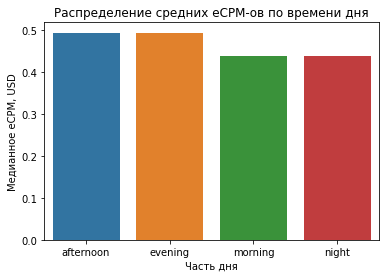

In [86]:
plt.figure(figsize=(6,4))
sns.barplot(data=BANNER_ecpm_per_day_part, y='median_ecpm', x='part_of_day')
plt.title('Распределение средних eCPM-ов по времени дня')
plt.xlabel('Часть дня')
plt.ylabel('Медианное eCPM, USD');

Для баннеров особой разницы в зависимости не видим. 

**Распределение средних eCPM-ов по типу девайса**

In [87]:
BANNER_ecpm_per_device_type = df.query('ad_type == "banner"') \
    .groupby('device_type', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

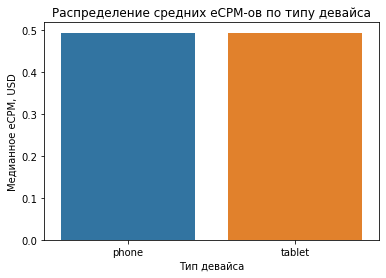

In [88]:
plt.figure(figsize=(6,4))
sns.barplot(data=BANNER_ecpm_per_device_type, y='median_ecpm', x='device_type')
plt.title('Распределение средних eCPM-ов по типу девайса')
plt.xlabel('Тип девайса')
plt.ylabel('Медианное eCPM, USD');

Никакой разницы. 

**Распределение средних eCPM-ов по производителю девайса**

In [89]:
BANNER_ecpm_per_device_manufacturer = df.query('ad_type == "banner"') \
    .groupby('device_manufacturer', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

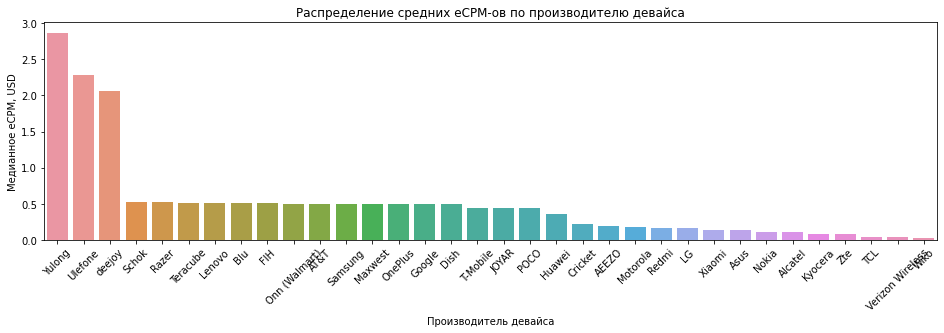

In [90]:
plt.figure(figsize=(16,4))
sns.barplot(data=BANNER_ecpm_per_device_manufacturer, y='median_ecpm', x='device_manufacturer')
plt.title('Распределение средних eCPM-ов по производителю девайса')
plt.xlabel('Производитель девайса')
plt.ylabel('Медианное eCPM, USD');
plt.xticks(rotation=45);

Три производителя девайсов (Yulong, Ulefone и deejoy) показывают медианный eCPM в 4-5 раз больше, чем остальные. Сколько показов баннеров приходится на них?

In [91]:
top_manufactureres = ['Yulong', 'Ulefone', 'deejoy']
df.query('device_manufacturer in @top_manufactureres & ad_type == "banner"').shape[0]

39

Таких показов всего 39 (из 800 тысяч), но все равно любопытно - почему они получают такой большой eCPM. 

**Распределение средних eCPM-ов по рекламной сети**

In [92]:
BANNER_ecpm_per_network_name = df.query('ad_type == "banner"') \
    .groupby('network_name', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

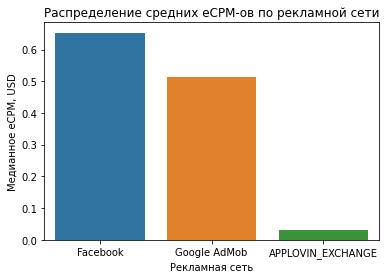

In [93]:
plt.figure(figsize=(6,4))
sns.barplot(data=BANNER_ecpm_per_network_name, y='median_ecpm', x='network_name')
plt.title('Распределение средних eCPM-ов по рекламной сети')
plt.xlabel('Рекламная сеть')
plt.ylabel('Медианное eCPM, USD');

Очень дешевые баннеры от APPLOVIN_EXCHANGE. Посмотрим на количество показов. 

In [94]:
BANNER_events_per_network_name = df.query('ad_type == "banner"') \
    .groupby('network_name', as_index=False) \
    .agg({'profile_id':'count'}) \
    .rename(columns={'profile_id':'events_count'}) \
    .sort_values(by='events_count', ascending=False)

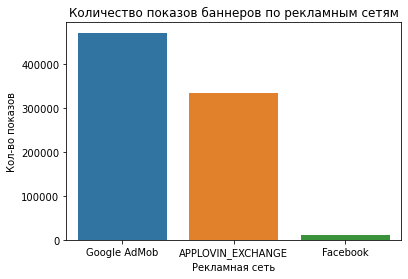

In [95]:
plt.figure(figsize=(6,4))
sns.barplot(data=BANNER_events_per_network_name, y='events_count', x='network_name')
plt.title('Количество показов баннеров по рекламным сетям')
plt.xlabel('Рекламная сеть')
plt.ylabel('Кол-во показов');

Ситуация прямопротивоположная. Фейсбук приносит мало показов, но платит больше всех. А вот APPLOVIN показывает рекламу в сотни раз чаще, но приносит в несколько раз меньше. Стоит перенастроить распределение. 

### Формат int

**Распределение средних eCPM-ов юзеров**

In [96]:
INT_ecmp_per_user = df.query('ad_type == "int"') \
    .groupby('profile_id', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'})

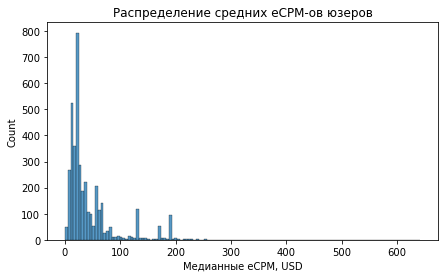

In [97]:
plt.figure(figsize=(7,4))
sns.histplot(data=INT_ecmp_per_user, x='median_ecpm')
plt.title('Распределение средних eCPM-ов юзеров')
plt.xlabel('Медианные eCPM, USD');

Основная масса значений лежит в диапозоне от 0 до 100 USD. Мы видим медианный пик на графике и помним, что медиана равна 21.4 USD. 

**Распределение eCPM-ов по городам**

Городов достаточно много, поэтому посмотрим топ-20.

In [98]:
INT_ecmp_per_city = df.query('ad_type == "int"') \
    .groupby('city', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

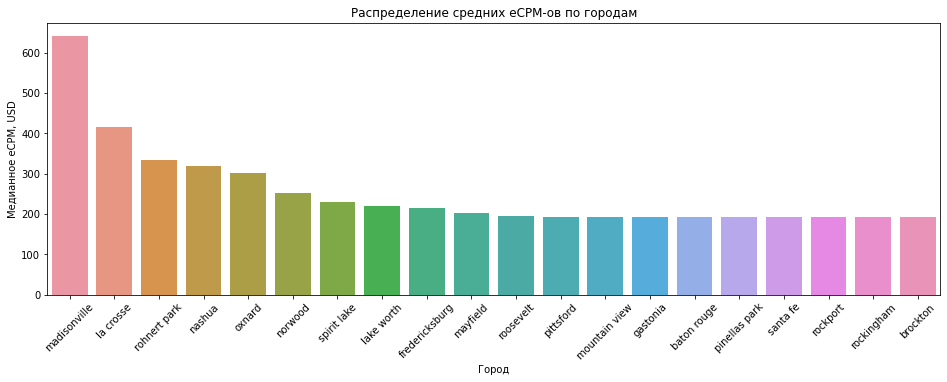

In [99]:
plt.figure(figsize=(16,5))
sns.barplot(data=INT_ecmp_per_city.head(20), y='median_ecpm', x='city')
plt.title('Распределение средних eCPM-ов по городам')
plt.xlabel('Город')
plt.ylabel('Медианное eCPM, USD')
plt.xticks(rotation=45);

Снова видим высокие значения у пары городов в начале. Чтобы проверить релевантность этих значений - возьмём все города топ-20 и посмотрим количество показов по ним. 

In [100]:
top_int_ecmp_city = INT_ecmp_per_city.head(20)['city']

In [101]:
INT_events_per_top_cities = df.query('ad_type == "int" & city in @top_int_ecmp_city') \
    .groupby('city', as_index=False) \
    .agg({'profile_id':'count'}) \
    .rename(columns={'profile_id':'event_counts'}) \
    .sort_values(by='event_counts', ascending=False)

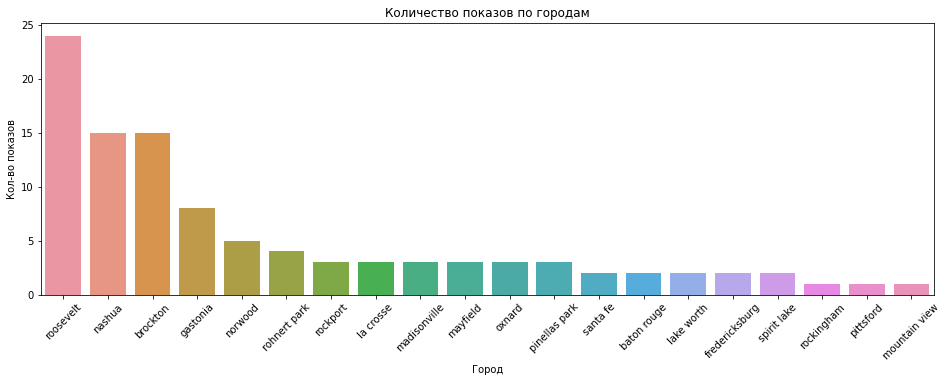

In [102]:
plt.figure(figsize=(16,5))
sns.barplot(data=INT_events_per_top_cities, y='event_counts', x='city')
plt.title('Количество показов по городам')
plt.xlabel('Город')
plt.ylabel('Кол-во показов')
plt.xticks(rotation=45);

In [103]:
df.query('ad_type == "int"') \
    .groupby('city', as_index=False) \
    .agg({'profile_id':'count'}) \
    .rename(columns={'profile_id':'event_counts'}) \
    .sort_values(by='event_counts', ascending=False) \
    ['event_counts'].mean()

27.40736478711162

Среднее количество показов int-формата среди городов - 27, а в нашем топ-20 лишь 3 города приближаются к этому значению. 

**Вывод:** В городах с высоким eCPM достаточно мало показов. Возможно - это точка для роста: работать над привлечением пользователей в этих городах. На Roosvelt стоит обратить внимание - там высокий (относительно медианы) eCPM и среднее количество по показам.  

**Распределение eCPM-ов по версиям ОС**

In [104]:
INT_ecpm_per_os = df.query('ad_type == "int"') \
    .groupby('os_version', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

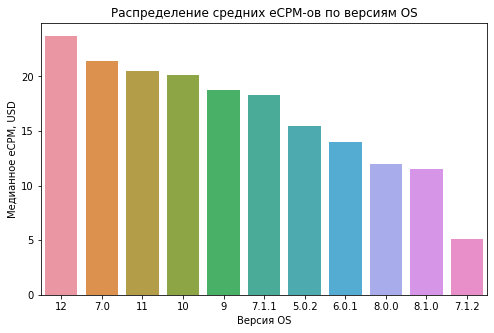

In [105]:
plt.figure(figsize=(8,5))
sns.barplot(data=INT_ecpm_per_os, y='median_ecpm', x='os_version')
plt.title('Распределение средних eCPM-ов по версиям OS')
plt.xlabel('Версия OS')
plt.ylabel('Медианное eCPM, USD');

А вот для формата int ситуация с распределением eCPM по версиям ОС уже выглядит иначе. Топовые версии в целом находятся в вершине списка, но отличия уже не такие существенные, а другие версии разбросаны достачно хаотично. Посмотрим так же на количество показов. 

In [106]:
INT_events_per_os_version = df.query('ad_type == "int"') \
    .groupby('os_version', as_index=False) \
    .agg({'profile_id':'count'}) \
    .rename(columns={'profile_id':'events_count'}) \
    .sort_values(by='events_count', ascending=False)

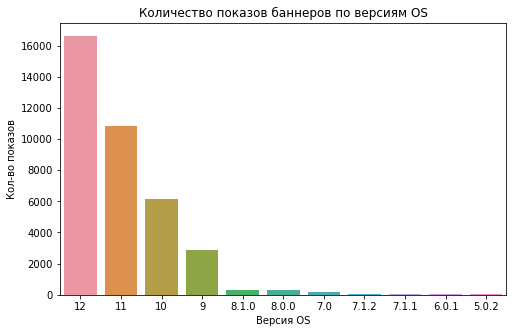

In [107]:
plt.figure(figsize=(8,5))
sns.barplot(data=INT_events_per_os_version, y='events_count', x='os_version')
plt.title('Количество показов баннеров по версиям OS')
plt.xlabel('Версия OS')
plt.ylabel('Кол-во показов');

**Вывод**

Новизна версии ОС не так сильно влияет на eCPM (хотя новые версии все же находятся в топе) для формата INT. А вот с показами ситуация такая же как и у баннеров: чем новее ОС - тем больше показов. Но, возможно, здесь дело только в том, что у пользователей в целом гораздо больше смартфонов с новыми версиями ОС.

**Распределение доходов по городам**

In [108]:
INT_total_revenue_per_city = df.query('ad_type == "int"') \
    .groupby('city', as_index=False) \
    .agg({'revenue':'sum'}) \
    .rename(columns={'revenue':'revenue_sum'}) \
    .sort_values(by='revenue_sum', ascending=False)

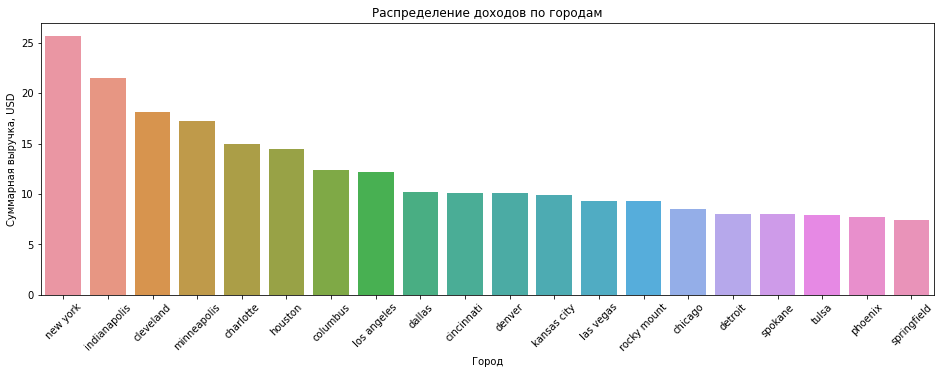

In [109]:
plt.figure(figsize=(16,5))
sns.barplot(data=INT_total_revenue_per_city.head(20), y='revenue_sum', x='city')
plt.title('Распределение доходов по городам')
plt.xlabel('Город')
plt.ylabel('Суммарная выручка, USD')
plt.xticks(rotation=45);

Повторяется ситуация как с баннерами. Первая пятерка городов по eCPM не попадала даже в топ-20 по доходам. А сам список городов по суммарной вырчке очень похож на такой же список для баннеров.

**Распределение доходов по версиям OS**

In [110]:
INT_total_revenue_per_os = df.query('ad_type == "int"') \
    .groupby('os_version', as_index=False) \
    .agg({'revenue':'sum'}) \
    .rename(columns={'revenue':'revenue_sum'}) \
    .sort_values(by='revenue_sum', ascending=False)

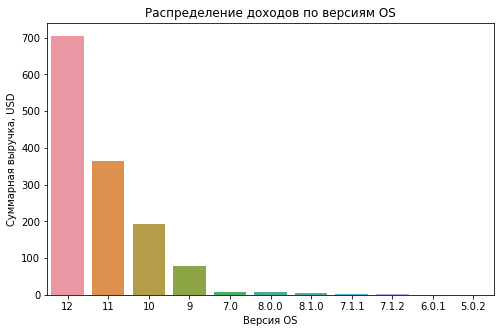

In [111]:
plt.figure(figsize=(8,5))
sns.barplot(data=INT_total_revenue_per_os, y='revenue_sum', x='os_version')
plt.title('Распределение доходов по версиям OS')
plt.xlabel('Версия OS')
plt.ylabel('Суммарная выручка, USD');

Здесь ситуация лишь подтверждает вывод предыдущих графиков. Причем явно видна зависимость дохода от версии OS. Чем новее, тем больше сумма дохода. 

**Распределение средних eCPM-ов по месту показа в игре**

In [112]:
INT_ecpm_per_device_type = df.query('ad_type == "int"') \
    .groupby('placement', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

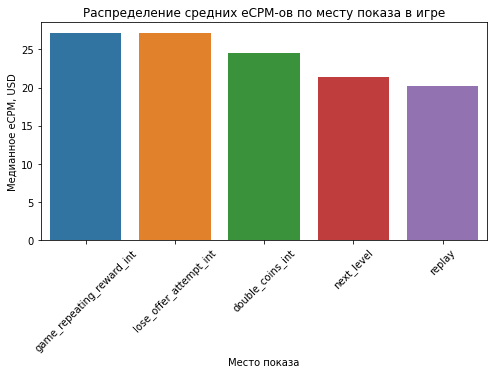

In [113]:
plt.figure(figsize=(8,4))
sns.barplot(data=INT_ecpm_per_device_type, y='median_ecpm', x='placement')
plt.title('Распределение средних eCPM-ов по месту показа в игре')
plt.xlabel('Место показа')
plt.ylabel('Медианное eCPM, USD');
plt.xticks(rotation=45);

Особо сильных отличий нет. Replay показывает меньший eCPM, а game_repeating_reward - больший. 

**Распределение средних eCPM-ов по времени дня**

In [114]:
INT_ecpm_per_day_part = df.query('ad_type == "int"') \
    .groupby('part_of_day', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

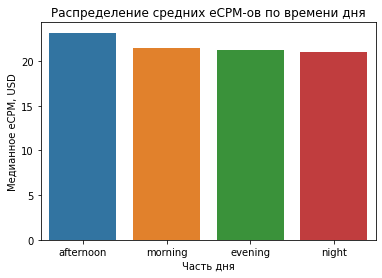

In [115]:
plt.figure(figsize=(6,4))
sns.barplot(data=INT_ecpm_per_day_part, y='median_ecpm', x='part_of_day')
plt.title('Распределение средних eCPM-ов по времени дня')
plt.xlabel('Часть дня')
plt.ylabel('Медианное eCPM, USD');

Снова нет зависимости от времени суток.  

**Распределение средних eCPM-ов по типу девайса**

In [116]:
INT_ecpm_per_device_type = df.query('ad_type == "int"') \
    .groupby('device_type', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

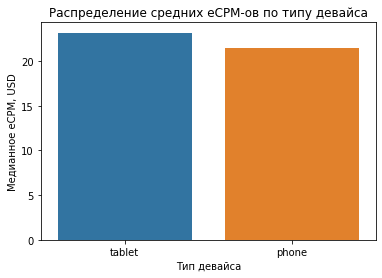

In [117]:
plt.figure(figsize=(6,4))
sns.barplot(data=INT_ecpm_per_device_type, y='median_ecpm', x='device_type')
plt.title('Распределение средних eCPM-ов по типу девайса')
plt.xlabel('Тип девайса')
plt.ylabel('Медианное eCPM, USD');

Большой разницы нет, но показы на планшетах чуть дороже. 

**Распределение средних eCPM-ов по производителю девайса**

In [118]:
INT_ecpm_per_device_manufacturer = df.query('ad_type == "int"') \
    .groupby('device_manufacturer', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

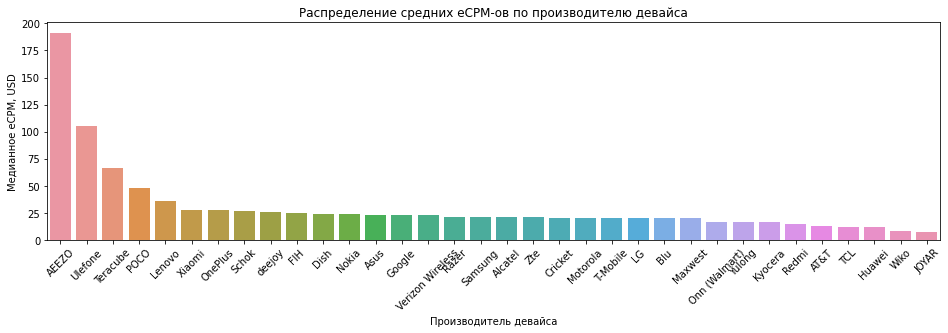

In [119]:
plt.figure(figsize=(16,4))
sns.barplot(data=INT_ecpm_per_device_manufacturer, y='median_ecpm', x='device_manufacturer')
plt.title('Распределение средних eCPM-ов по производителю девайса')
plt.xlabel('Производитель девайса')
plt.ylabel('Медианное eCPM, USD');
plt.xticks(rotation=45);

Три производителя девайсов (AEEZO, Ulefone, Teracube и POCO) показывают медианный eCPM гораздо выше остальных. Сколько показов баннеров приходится на них?

In [120]:
top_manufactureres = ['Yulong', 'AEEZO', 'Teracube', 'POCO']
df.query('device_manufacturer in @top_manufactureres & ad_type == "banner"').shape[0]

357

In [121]:
df.query('ad_type == "int"').shape[0]

37609

Таких показов всего 1%, но тем не менее - интересно почему они получают такой большой eCPM. 

**Распределение средних eCPM-ов по рекламной сети**

In [122]:
INT_ecpm_per_network_name = df.query('ad_type == "int"') \
    .groupby('network_name', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

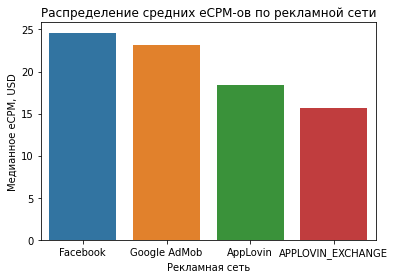

In [123]:
plt.figure(figsize=(6,4))
sns.barplot(data=INT_ecpm_per_network_name, y='median_ecpm', x='network_name')
plt.title('Распределение средних eCPM-ов по рекламной сети')
plt.xlabel('Рекламная сеть')
plt.ylabel('Медианное eCPM, USD');

Facebook снова показывает наибольший eCPM, а сервисы от APPLOVIN - меньший. Посмотрим на количество показов. 

In [124]:
INT_events_per_network_name = df.query('ad_type == "int"') \
    .groupby('network_name', as_index=False) \
    .agg({'profile_id':'count'}) \
    .rename(columns={'profile_id':'events_count'}) \
    .sort_values(by='events_count', ascending=False)

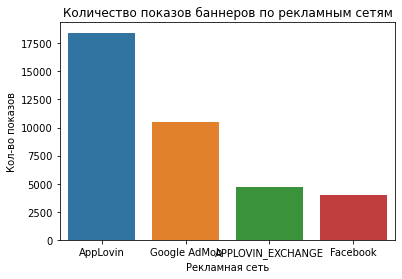

In [125]:
plt.figure(figsize=(6,4))
sns.barplot(data=INT_events_per_network_name, y='events_count', x='network_name')
plt.title('Количество показов баннеров по рекламным сетям')
plt.xlabel('Рекламная сеть')
plt.ylabel('Кол-во показов');

И снова аналогичная ситуация. APPLOVIN переоценен по количеству показов, а Facebook - недооценен. 

### Формат rv

**Распределение средних eCPM-ов юзеров**

In [126]:
RV_ecpm_per_user = df.query('ad_type == "rv"') \
    .groupby('profile_id', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'})

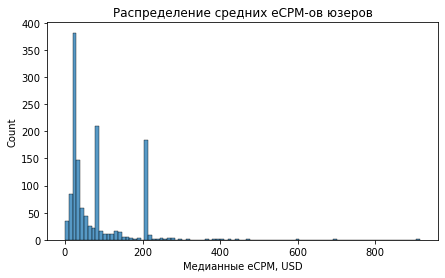

In [127]:
plt.figure(figsize=(7,4))
sns.histplot(data=RV_ecpm_per_user, x='median_ecpm')
plt.title('Распределение средних eCPM-ов юзеров')
plt.xlabel('Медианные eCPM, USD');

Основная масса значений лежит в диапозоне от 0 до 200 USD. Есть основной пик где-то в области медианы (31.5 rv), а еще два достаточно заметных пика около 200 и около 90-100. Посмотрим почему так много таких значний. 

In [128]:
RV_ecpm_per_user.query('median_ecpm > 200 & median_ecpm < 220')['median_ecpm'].value_counts().head(5)

211.700000    177
211.699997      4
211.699998      3
216.992502      2
218.358063      1
Name: median_ecpm, dtype: int64

In [129]:
RV_ecpm_per_user.query('median_ecpm > 80 & median_ecpm < 90')['median_ecpm'].value_counts().head(5)

80.640000    180
85.199803      1
81.128147      1
80.749390      1
80.377121      1
Name: median_ecpm, dtype: int64

Есть большая группа юзеров со значениями ecpm равными 211.7 и 80.64. Сложно, чтобы медиана с 6 знаками после запятой совпала так много раз. Скорее всего - у этих юзеров есть всего один показ rv рекламы с одинаковой стоимостью. Проверим. 

In [130]:
df.query('ad_type == "rv" & ecpm == 211.7').shape[0]

677

In [131]:
df.query('ad_type == "rv" & ecpm == 80.64').shape[0]

880

Действительно, так и есть. Интересно, почему так много совпадений одного значения. Посмотрим - чем они все объединены. 

In [132]:
df.query('ad_type == "rv" & ecpm == 211.7 | ecpm == 80.64')['device_type'].value_counts()

phone     1523
tablet      34
Name: device_type, dtype: int64

In [133]:
df.query('ad_type == "rv" & ecpm == 211.7 | ecpm == 80.64')['event_datetime'].dt.hour.value_counts().head(10)

5     125
4     105
23     99
6      95
3      93
1      85
0      81
7      80
22     73
18     73
Name: event_datetime, dtype: int64

In [134]:
df.query('ad_type == "rv" & ecpm == 211.7 | ecpm == 80.64')['network_name'].value_counts()

Google AdMob    1557
Name: network_name, dtype: int64

In [135]:
df.query('ad_type == "rv" & ecpm == 211.7 | ecpm == 80.64')['placement'].value_counts()

lose_offer_attempt       1101
double_coins              301
game_repeating_reward     155
Name: placement, dtype: int64

1. Это показы на телефонах
2. Чаще всего в ночные часы
3. Скорее всего место размещения в игре - lose_offer_attempt 
3. И самое главное - все от сети Google AdMod. 

Интересные знания по RV. Стоит учесть это для настройки запроса рекламы. 

**Распределение eCPM-ов по городам**

Городов достаточно много, поэтому посмотрим топ-20.

In [136]:
RV_ecpm_per_city = df.query('ad_type == "rv"') \
    .groupby('city', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

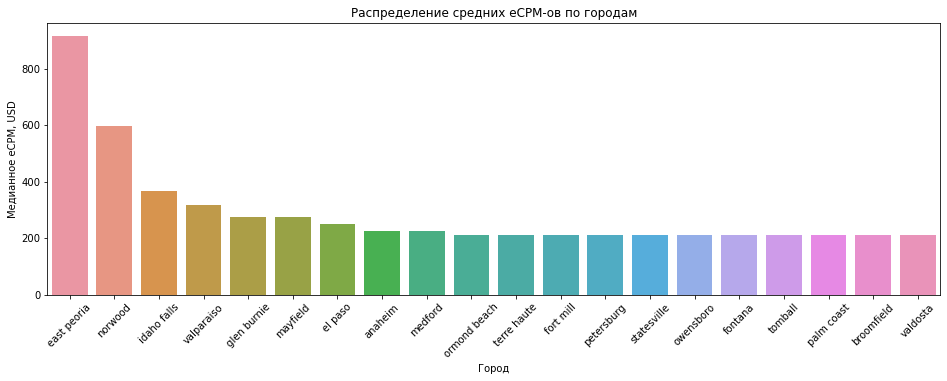

In [137]:
plt.figure(figsize=(16,5))
sns.barplot(data=RV_ecpm_per_city.head(20), y='median_ecpm', x='city')
plt.title('Распределение средних eCPM-ов по городам')
plt.xlabel('Город')
plt.ylabel('Медианное eCPM, USD')
plt.xticks(rotation=45);

Снова схожая картина. Два высоких значений ecpm у двух городов, а дальше - плавное снижение. Посмотрим количество показов по этим городам. 

In [138]:
top_rv_ecpm_city = RV_ecpm_per_city.head(20)['city']

In [139]:
RV_events_per_top_cities = df.query('ad_type == "int" & city in @top_rv_ecpm_city') \
    .groupby('city', as_index=False) \
    .agg({'profile_id':'count'}) \
    .rename(columns={'profile_id':'event_counts'}) \
    .sort_values(by='event_counts', ascending=False)

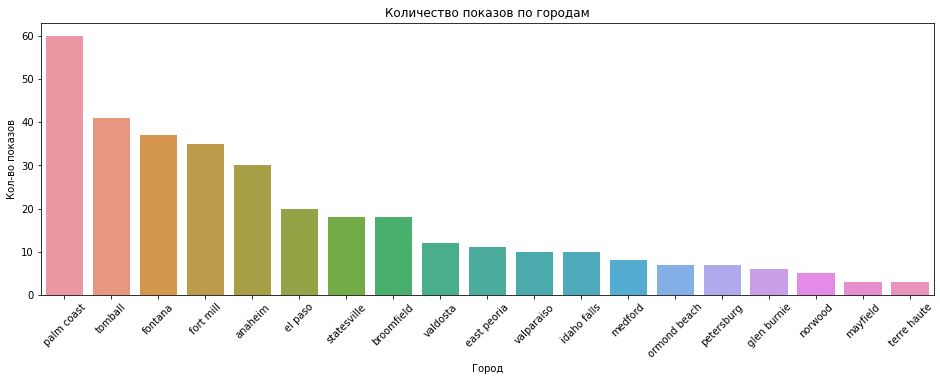

In [140]:
plt.figure(figsize=(16,5))
sns.barplot(data=RV_events_per_top_cities, y='event_counts', x='city')
plt.title('Количество показов по городам')
plt.xlabel('Город')
plt.ylabel('Кол-во показов')
plt.xticks(rotation=45);

In [141]:
df.query('ad_type == "rv"') \
    .groupby('city', as_index=False) \
    .agg({'profile_id':'count'}) \
    .rename(columns={'profile_id':'event_counts'}) \
    .sort_values(by='event_counts', ascending=False) \
    ['event_counts'].mean()

9.607929515418503

**Вывод**
Большая часть городов из топ-20 по eCPM приносит среднее и выше среднего значение по количеству показов. Этот вывод отличается от выводов про RV и Banner. На городок east_peoria можно обратить особое внимание.

**Распределение eCPM-ов по версиям ОС**

In [142]:
RV_ecpm_per_os = df.query('ad_type == "rv"') \
    .groupby('os_version', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

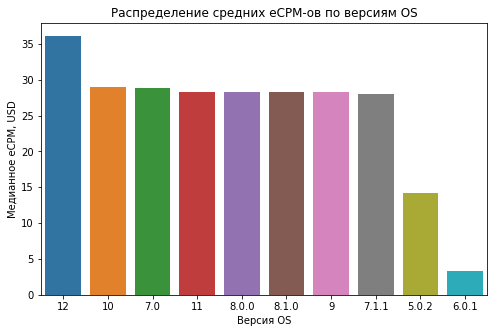

In [143]:
plt.figure(figsize=(8,5))
sns.barplot(data=RV_ecpm_per_os, y='median_ecpm', x='os_version')
plt.title('Распределение средних eCPM-ов по версиям OS')
plt.xlabel('Версия OS')
plt.ylabel('Медианное eCPM, USD');

Судя по всему eCPM формата RV не так драматично зависит от версии ОС, нежели формат баннер. 

In [144]:
RV_events_per_os_version = df.query('ad_type == "rv"') \
    .groupby('os_version', as_index=False) \
    .agg({'profile_id':'count'}) \
    .rename(columns={'profile_id':'events_count'}) \
    .sort_values(by='events_count', ascending=False)

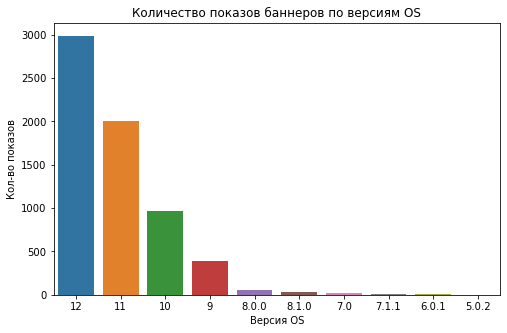

In [145]:
plt.figure(figsize=(8,5))
sns.barplot(data=RV_events_per_os_version, y='events_count', x='os_version')
plt.title('Количество показов баннеров по версиям OS')
plt.xlabel('Версия OS')
plt.ylabel('Кол-во показов');

С количеством событий ничего нового. Чем новее версия ОС, тем больше событий. 

**Распределение доходов по городам**

In [146]:
RV_total_revenue_per_city = df.query('ad_type == "rv"') \
    .groupby('city', as_index=False) \
    .agg({'revenue':'sum'}) \
    .rename(columns={'revenue':'revenue_sum'}) \
    .sort_values(by='revenue_sum', ascending=False)

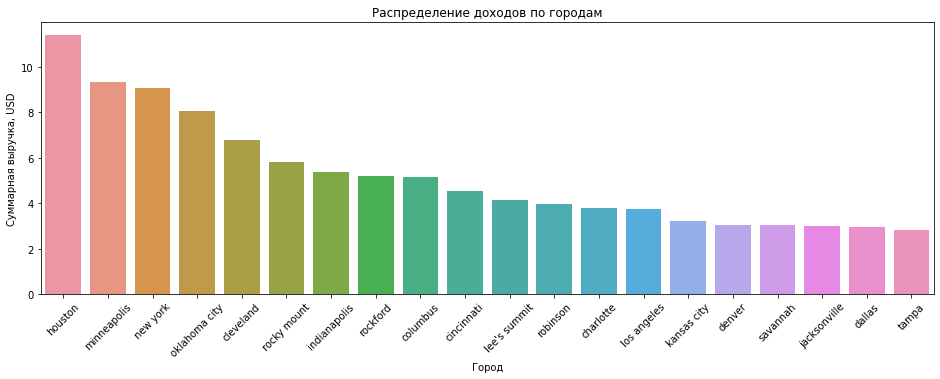

In [147]:
plt.figure(figsize=(16,5))
sns.barplot(data=RV_total_revenue_per_city.head(20), y='revenue_sum', x='city')
plt.title('Распределение доходов по городам')
plt.xlabel('Город')
plt.ylabel('Суммарная выручка, USD')
plt.xticks(rotation=45);

Повторяется ситуация как с баннерами. Лидеры по eCPM не попадают в список лидеров по доходам.

**Распределение доходов по версиям OS**

In [148]:
RV_total_revenue_per_os = df.query('ad_type == "rv"') \
    .groupby('os_version', as_index=False) \
    .agg({'revenue':'sum'}) \
    .rename(columns={'revenue':'revenue_sum'}) \
    .sort_values(by='revenue_sum', ascending=False)

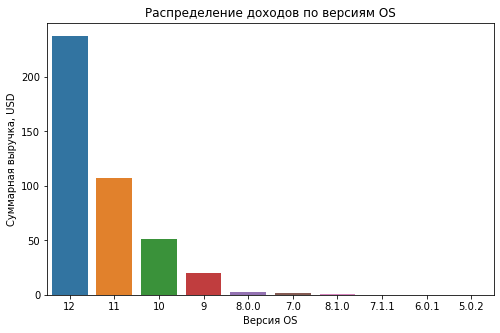

In [149]:
plt.figure(figsize=(8,5))
sns.barplot(data=RV_total_revenue_per_os, y='revenue_sum', x='os_version')
plt.title('Распределение доходов по версиям OS')
plt.xlabel('Версия OS')
plt.ylabel('Суммарная выручка, USD');

Здесь мало новой информации. eCPM практически одинаковый, а число показов растет для более новых версий. Получаем примерно так же возрастающий график. 

**Распределение средних eCPM-ов по месту показа в игре**

In [150]:
RV_ecpm_per_device_type = df.query('ad_type == "rv"') \
    .groupby('placement', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

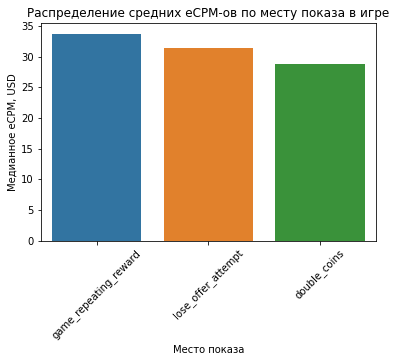

In [151]:
plt.figure(figsize=(6,4))
sns.barplot(data=RV_ecpm_per_device_type, y='median_ecpm', x='placement')
plt.title('Распределение средних eCPM-ов по месту показа в игре')
plt.xlabel('Место показа')
plt.ylabel('Медианное eCPM, USD');
plt.xticks(rotation=45);

Особо сильных отличий нет. Game_repeating_reward - снова показывает наибольший eCPM. 

**Распределение средних eCPM-ов по времени дня**

In [152]:
RV_ecpm_per_day_part = df.query('ad_type == "rv"') \
    .groupby('part_of_day', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

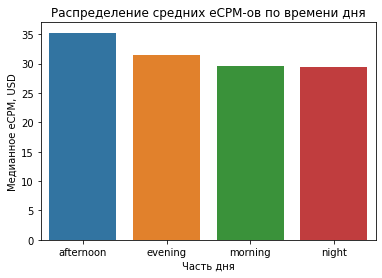

In [153]:
plt.figure(figsize=(6,4))
sns.barplot(data=RV_ecpm_per_day_part, y='median_ecpm', x='part_of_day')
plt.title('Распределение средних eCPM-ов по времени дня')
plt.xlabel('Часть дня')
plt.ylabel('Медианное eCPM, USD');

Снова нет сильных отличий, но после трех исследований времени показа можно заметить, что каждый формат лучше оплачивается днём: с 10 до 18. 

**Распределение средних eCPM-ов по типу девайса**

In [154]:
RV_ecpm_per_device_type = df.query('ad_type == "rv"') \
    .groupby('device_type', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

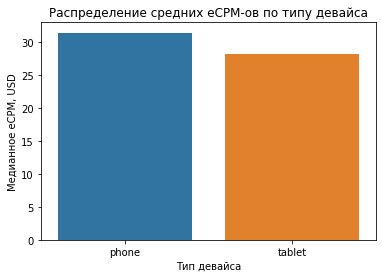

In [155]:
plt.figure(figsize=(6,4))
sns.barplot(data=RV_ecpm_per_device_type, y='median_ecpm', x='device_type')
plt.title('Распределение средних eCPM-ов по типу девайса')
plt.xlabel('Тип девайса')
plt.ylabel('Медианное eCPM, USD');

Большой разницы нет, показы на телефонах чуть дороже. 

**Распределение средних eCPM-ов по производителю девайса**

In [156]:
RV_ecpm_per_device_manufacturer = df.query('ad_type == "rv"') \
    .groupby('device_manufacturer', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

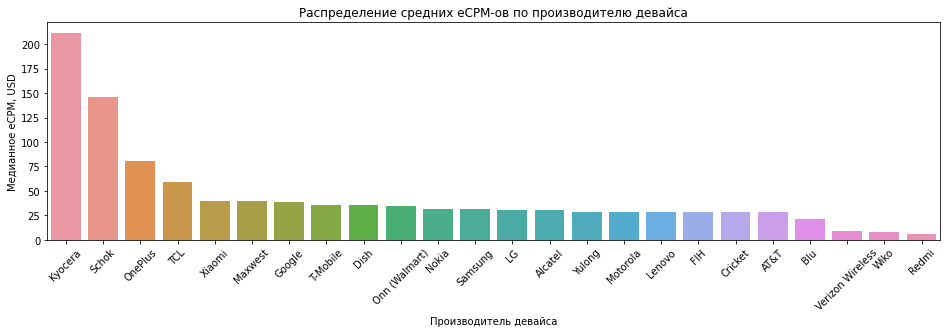

In [158]:
plt.figure(figsize=(16,4))
sns.barplot(data=RV_ecpm_per_device_manufacturer, y='median_ecpm', x='device_manufacturer')
plt.title('Распределение средних eCPM-ов по производителю девайса')
plt.xlabel('Производитель девайса')
plt.ylabel('Медианное eCPM, USD');
plt.xticks(rotation=45);

Cнова аналогичная ситуация: есть несколько дейвасов, показы на которых оплачиваются дороже (иногда сильно дороже). Для rv - это Kyocer, Schok, OnePlus и TCL. Сколько показов баннеров приходится на них?

In [159]:
top_manufactureres = ['Kyocer', 'Schok', 'OnePlus', 'TCL']
df.query('device_manufacturer in @top_manufactureres & ad_type == "rv"').shape[0]

110

In [160]:
df.query('ad_type == "rv"').shape[0]

6482

Всего около 2% показов.

**Распределение средних eCPM-ов по рекламной сети**

In [161]:
RV_ecpm_per_network_name = df.query('ad_type == "rv"') \
    .groupby('network_name', as_index=False) \
    .agg({'ecpm':'median'}) \
    .rename(columns={'ecpm':'median_ecpm'}) \
    .sort_values(by='median_ecpm', ascending=False)

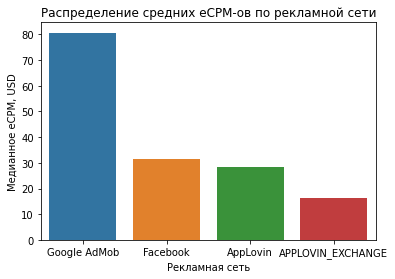

In [162]:
plt.figure(figsize=(6,4))
sns.barplot(data=RV_ecpm_per_network_name, y='median_ecpm', x='network_name')
plt.title('Распределение средних eCPM-ов по рекламной сети')
plt.xlabel('Рекламная сеть')
plt.ylabel('Медианное eCPM, USD');

В лидерах по rv - Google AdMob. Остальные сети платят в среднем в два раза меньше. 

In [163]:
RV_events_per_network_name = df.query('ad_type == "rv"') \
    .groupby('network_name', as_index=False) \
    .agg({'profile_id':'count'}) \
    .rename(columns={'profile_id':'events_count'}) \
    .sort_values(by='events_count', ascending=False)

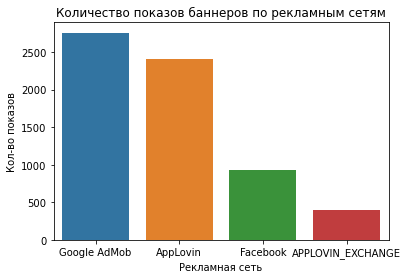

In [164]:
plt.figure(figsize=(6,4))
sns.barplot(data=RV_events_per_network_name, y='events_count', x='network_name')
plt.title('Количество показов баннеров по рекламным сетям')
plt.xlabel('Рекламная сеть')
plt.ylabel('Кол-во показов');

И наибольшее количество показов тоже у Google. При этом снова немного переоценен AppLovin, который приносит меньший eCPM, чем Фейсбук, а показывает рекламу в нашем приложении в два раза чаще.

## Выводы

### Наблюдения и вопросы коллегам

1. Даты в столбцах event_datetime и event_timestamp, а так же столбцах event_receive_datetime и event_receive_timestamp  отличаются на 3 часа. Что с ними? Почему так?
2. У нас либо неполные данные, либо с 29 января по 3 февраля драматически падает активность пользователей. 

### Общие выводы

**Медианные значения eCPM**
- banner: 0.49 USD
- int: 21.4 USD
- rv: 31.5 USD

**Общие наблюдения для всех форматов рекламы**
- Среднее количество показов рекламы (по всем форматам) на 1 юзера - 57. 
- Баннеры имеют 95% всех показов рекламы, но при этом приносят всего лишь 25% выручки, в то время как RV при 0.4% показов приносит почти 18% выручки. 
- eCPM не сильно зависит от времени суток, но есть один тренд: днем (с 10 до 18) средний eCPM выше для всех типов рекламы. 
- eCPM не сильно отличается по типу девайса
- Для каждого типа рекламы есть несколько производителей девайсов, которые показывают очень высокий (в сравнении с другими eCPM). У них мало показов, но это все равно интересная точка для изучения. Почему именно эти производители?
- В городах с самыми высокими eCPM обычно мало показов, в сравнении с другими. Это справедливо для всех форматов рекламы. Возможно - это точка для роста: работать над привлечением пользователей в городах с высоким eCPM. 

### Формат banner

- Более новые версии OS (12, 10, 9, 11) показывают минимум в 4 раза больший eCPM в сравнении со старыми. Основная часть показов, а следовательно и выручки также приходится на них. 
- Рекламная сеть очень четко влияет на eCPM. **При этом, обратите внимание: фейсбук редко показывает рекламу, но платит больше всех, а APPLOVIN наоборот показывает рекламу в сотни раз чаще, но имеет очень низкий eCPM. Стоит перенастроить распределение.**

### Формат int - полноэкранная реклама

- Версия ОС уже не так очевидно влияет на eCPM для полноэкранной рекламы. И хотя топовые версии в целом находятся в вершине списка, отличия уже не такие существенные. Но из-за количества показов новые версии все равно приносят больше выручки. 
- Место показа в игре не сильно влияет на eCPM. Replay показывает меньший eCPM, а game_repeating_reward - больший.
- Снова видим отличия по eCPM в зависимости от рекламной сети. **И снова аналогичная ситуация. APPLOVIN переоценен по количеству показов (много показов, но меньше eCPM), а Facebook - недооценен (больший eCPM, но мало показов).** 

### Формат rv - видео за вознаграждение

- eCPM практически не зависит от версии ОС, но новые версии все равно приносят больше выручки из-за количества показов. 
- Место показа в игре не влияет на eCPM драматически. Game_repeating_reward - снова показывает наибольший eCPM.
- Самый высокий eCPM приносит рекламная сеть от Google. Она же чаще других оказывает рекламу. **Но и здесь переоценен AppLovin, который приносит меньший eCPM, чем Фейсбук, а показывает рекламу в нашем приложении в два раза чаще.**

**А еще:**
У формата rv есть заметно много показов, которые имеют неожиданно большой eCPM (212 и 81, при медиане в 31). Для этих показов есть несколько характерных черт:
1. Это показы на телефонах
2. Чаще всего в ночные часы
3. Скорее всего место размещения в игре - lose_offer_attempt 
3. И самое главное - все от сети Google AdMod. 
Стоит учесть это при настройке запроса рекламы по RV.